In [1]:
import os
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pylab
import audio_preprocessing as aupr

In [2]:
os.listdir()

['genre_classification.ipynb',
 '__pycache__',
 'genres.tar.gz',
 '.ipynb_checkpoints',
 'mel',
 'audio_preprocessing.py',
 'genres',
 'conversion.py',
 'data',
 'helper_images']

## Some audio plots

In [3]:
aupr.random_10_seconds('./data')

./data/disco/disco.00035.wav
30.013333333333332


Text(0.5,1,'Waveplot')

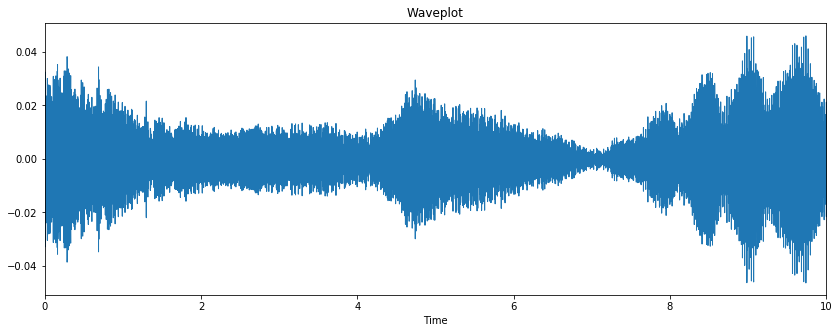

In [4]:
path = './data/classical/classical.00033.wav'
y, sr = librosa.load(path)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y[:10*sr], sr)
plt.title('Waveplot')

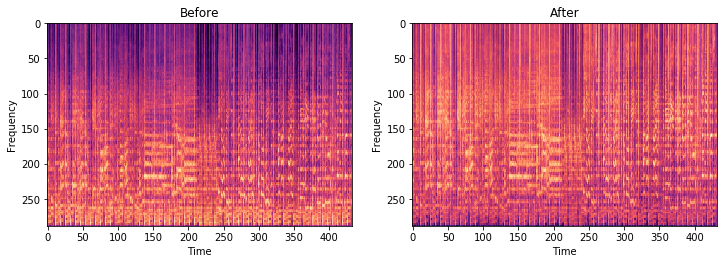

In [5]:
fig = plt.figure(figsize=(12, 8))
images = ['helper_images/before_processing.jpg', 'helper_images/after_processing.jpg']
titles = ['Before', 'After']
for i in range(1, 3):
    ax = fig.add_subplot(1, 2, i)
    im = Image.open(images[i-1])
    plt.title(titles[i-1])
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.imshow(im)

## Fully preprocessed MEL-spectrogram used as an input to CNN

Text(0.5,1,'MEL-spectrogram')

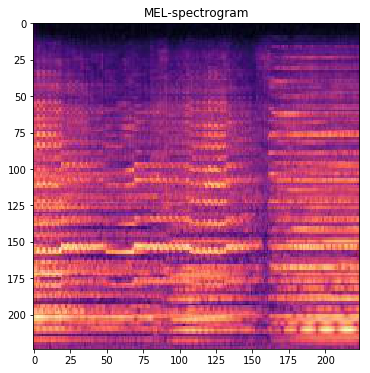

In [6]:
save_path = 'helper_images/sample'
aupr.full_preprocess(path, save_path)
plt.figure(figsize=(6, 6))
im = Image.open(save_path + '_0.jpg')
plt.imshow(im)
plt.title('MEL-spectrogram')

## Fine-tuned Resnet-34 with PyTorch

In [42]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.1
Torchvision Version:  0.2.2


In [43]:
torch.cuda.empty_cache()

In [44]:
data_dir = './mel'
model_name = 'resnet'
num_classes = 10
batch_size = 8
num_epochs = 15
feature_extract = False

In [45]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [46]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [47]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        """ RESNET 34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    return model_ft, input_size

In [32]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [49]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [50]:
model_ft = model_ft.to(device)

In [51]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1.

In [52]:
optimizer_ft = optim.Adam(params_to_update, lr=0.0001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [53]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.0377 Acc: 0.9900
test Loss: 0.6563 Acc: 0.8533

Epoch 1/14
----------
train Loss: 0.0200 Acc: 0.9950
test Loss: 0.6347 Acc: 0.8483

Epoch 2/14
----------
train Loss: 0.0178 Acc: 0.9950
test Loss: 0.6323 Acc: 0.8717

Epoch 3/14
----------
train Loss: 0.0184 Acc: 0.9954
test Loss: 0.6351 Acc: 0.8717

Epoch 4/14
----------
train Loss: 0.0251 Acc: 0.9938
test Loss: 0.7504 Acc: 0.8317

Epoch 5/14
----------
train Loss: 0.0318 Acc: 0.9925
test Loss: 0.7991 Acc: 0.8400

Epoch 6/14
----------
train Loss: 0.0148 Acc: 0.9958
test Loss: 0.7267 Acc: 0.8533

Epoch 7/14
----------
train Loss: 0.0086 Acc: 0.9975
test Loss: 0.7006 Acc: 0.8650

Epoch 8/14
----------
train Loss: 0.0054 Acc: 0.9979
test Loss: 0.6864 Acc: 0.8600

Epoch 9/14
----------
train Loss: 0.0061 Acc: 0.9988
test Loss: 0.7323 Acc: 0.8533

Epoch 10/14
----------
train Loss: 0.0176 Acc: 0.9950
test Loss: 0.8528 Acc: 0.8283

Epoch 11/14
----------
train Loss: 0.0377 Acc: 0.9883
test Loss: 0.7325 Acc

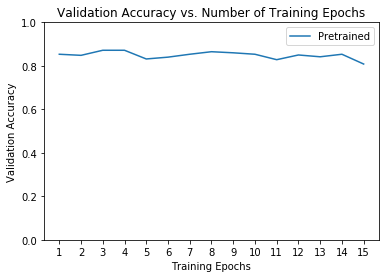

In [54]:
ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [55]:
torch.save(model_ft, './models/final.pt')